In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import necessary libaries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import itertools
import sys
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

## Load and preprocess data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Data2/ELG_Busan_PoC_per_CA_site_0226_0519.csv')


df.fillna(0, inplace=True)
df['hour'] = df['hour'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

rb_columns = ['RB_800', 'RB_1800', 'RB_2100', 'RB_2600_10', 'RB_2600_20']
features = ['hour', 'Holiday'] + rb_columns
grouped = df.groupby('enbid_pci')[features].resample('H').mean().reset_index()
grouped.set_index(['enbid_pci', 'timestamp'], inplace=True)
grouped = grouped.unstack(level='enbid_pci').swaplevel(axis=1).sort_index(axis=1)
grouped.fillna(0, inplace=True)

## Split Data into train and test sets

In [ ]:
TRAIN_RATIO = 0.8
train = grouped.iloc[:int(TRAIN_RATIO*len(grouped))]
test = grouped.iloc[int(TRAIN_RATIO*len(grouped)):]

## Define Helper Functions

In [ ]:
def prepare_prophet_data(data, target_column, regressor_columns):
    prophet_data = data.reset_index()[['timestamp'] + [target_column] + regressor_columns]
    prophet_data = prophet_data.rename(columns={'timestamp': 'ds', target_column: 'y'})

    scaler = StandardScaler()
    prophet_data[regressor_columns] = scaler.fit_transform(prophet_data[regressor_columns])

    return prophet_data, scaler

def optimize_prophet(data, param_grid):
    best_params, best_rmse = None, float('inf')
    for params in itertools.product(*param_grid.values()):
        model = Prophet(**dict(zip(param_grid.keys(), params)))
        for regressor in regressor_columns:
            model.add_regressor(regressor, mode='additive', standardize=False)
        model.fit(data)
        cv_results = cross_validation(model, initial='30 days', period='5 days', horizon='7 days')
        rmse = np.sqrt(performance_metrics(cv_results)['mse'].mean())
        if rmse < best_rmse:
            best_rmse, best_params = rmse, dict(zip(param_grid.keys(), params))
    return best_params

## Set up  main execution

In [ ]:
FREQUENCY = 'RB_800'
enbid_pci = grouped.columns.levels[0][0]
train_pick_one = train[enbid_pci]
test_pick_one = test[enbid_pci]
regressor_columns = [col for col in rb_columns if col != FREQUENCY] + ['hour', 'Holiday']

## Prepare Prophet Data

In [ ]:
prophet_data, scaler = prepare_prophet_data(train_pick_one, FREQUENCY, regressor_columns)


## Hyperparameter optimization


In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'daily_seasonality': [True, False],
    'weekly_seasonality': [True, False],
    'yearly_seasonality': [True, False]
}
best_params = optimize_prophet(prophet_data, param_grid)
print("Best hyperparameters:", best_params)

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/0udpaaod.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/3gons1v3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9299', 'data', 'file=/tmp/tmplo8b_dp3/0udpaaod.json', 'init=/tmp/tmplo8b_dp3/3gons1v3.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelteq7l09g/prophet_model-20240909082714.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:27:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:27:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2024-03-27 03:00:00 and 2024-04-26 03:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/rimjk6pf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/0picouyj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40383', 'data', 'file=/tmp/tmplo8b_dp3/rimjk6pf.json', 'init=/tmp/tmplo8b_dp3/0picouyj.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model4jt9hegv/prophet_model-20240909082715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:27:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:27:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ywnlwy_q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/7qzf6qgc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/2gslkdnu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/yxpftrhi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20491', 'data', 'file=/tmp/tmplo8b_dp3/2gslkdnu.json', 'init=/tmp/tmplo8b_dp3/yxpftrhi.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model1sx3lsky/prophet_model-20240909082719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:27:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:27:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/dx7qn_yz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/vbdk8bo1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/r0cty70q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/3wmhkjep.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66159', 'data', 'file=/tmp/tmplo8b_dp3/r0cty70q.json', 'init=/tmp/tmplo8b_dp3/3wmhkjep.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model5_z_vbit/prophet_model-20240909082722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:27:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:27:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/bnhro6y0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/hbp6u5o_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/b87uzynx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/td8jbnhm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28565', 'data', 'file=/tmp/tmplo8b_dp3/b87uzynx.json', 'init=/tmp/tmplo8b_dp3/td8jbnhm.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelklidqcfg/prophet_model-20240909082725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:27:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:27:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/340_ax0d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/in0ro30j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_7d9ne4n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/eodea5ey.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64350', 'data', 'file=/tmp/tmplo8b_dp3/_7d9ne4n.json', 'init=/tmp/tmplo8b_dp3/eodea5ey.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model8ta6tz7z/prophet_model-20240909082727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:27:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:27:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/2pqkjswe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/zmiusl87.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/m3a839w0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/vg08jw1z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93232', 'data', 'file=/tmp/tmplo8b_dp3/m3a839w0.json', 'init=/tmp/tmplo8b_dp3/vg08jw1z.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelw7taqfuw/prophet_model-20240909082730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:27:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:27:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/6279nk2c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/oxtlc10x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/g83omimw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/whr6yny9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31072', 'data', 'file=/tmp/tmplo8b_dp3/g83omimw.json', 'init=/tmp/tmplo8b_dp3/whr6yny9.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeljsev79p6/prophet_model-20240909082733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:27:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:27:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/on9ndqc8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/yn68uqyi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/4ov3962m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/k__fnbx6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26748', 'data', 'file=/tmp/tmplo8b_dp3/4ov3962m.json', 'init=/tmp/tmplo8b_dp3/k__fnbx6.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model8pr4hlng/prophet_model-20240909082737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:27:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:27:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/z6nou2er.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/3kj9f90z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/czqqudpe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/en_2we63.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1799', 'data', 'file=/tmp/tmplo8b_dp3/czqqudpe.json', 'init=/tmp/tmplo8b_dp3/en_2we63.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelfqgigsu2/prophet_model-20240909082739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:27:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:27:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/dzhuo702.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ka715msn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/2anw30yd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/4id2ke53.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53927', 'data', 'file=/tmp/tmplo8b_dp3/2anw30yd.json', 'init=/tmp/tmplo8b_dp3/4id2ke53.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelnvfmk80z/prophet_model-20240909082742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:27:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:27:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/af5_oacm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/8ziim6pl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/f2k397zn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/jz92mval.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43578', 'data', 'file=/tmp/tmplo8b_dp3/f2k397zn.json', 'init=/tmp/tmplo8b_dp3/jz92mval.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelf5uvtpkz/prophet_model-20240909082745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:27:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:27:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/wf8hxxmh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_91bs7mi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ac8hs4hr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/7u10v945.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93112', 'data', 'file=/tmp/tmplo8b_dp3/ac8hs4hr.json', 'init=/tmp/tmplo8b_dp3/7u10v945.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeln0pciyaz/prophet_model-20240909082752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:27:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:27:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/io4ci8v_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/gd6xnxlz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/hx882of2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/nv23kkfm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57228', 'data', 'file=/tmp/tmplo8b_dp3/hx882of2.json', 'init=/tmp/tmplo8b_dp3/nv23kkfm.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelrd3sz9yi/prophet_model-20240909082754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:27:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:27:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/mbxa4fid.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/8hf1ba30.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/8t8axuws.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/lpwnk5_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7792', 'data', 'file=/tmp/tmplo8b_dp3/8t8axuws.json', 'init=/tmp/tmplo8b_dp3/lpwnk5_p.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelrga_fyy0/prophet_model-20240909082757.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:27:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:27:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/x7tpt2y9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_d7xefyw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/9dq75ldx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/mukzt44r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61135', 'data', 'file=/tmp/tmplo8b_dp3/9dq75ldx.json', 'init=/tmp/tmplo8b_dp3/mukzt44r.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelb8mb3hcy/prophet_model-20240909082800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:28:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:28:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ealowizj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/yrbr5uz5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/g3w85t5_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/e37xazbt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39781', 'data', 'file=/tmp/tmplo8b_dp3/g3w85t5_.json', 'init=/tmp/tmplo8b_dp3/e37xazbt.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model_v044pyu/prophet_model-20240909082807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:28:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:28:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/t_j4bvhz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/cdny13v9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/3l9wb9nd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/i29aorsh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12469', 'data', 'file=/tmp/tmplo8b_dp3/3l9wb9nd.json', 'init=/tmp/tmplo8b_dp3/i29aorsh.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelapcgx2xn/prophet_model-20240909082810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:28:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:28:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/5dbi4o98.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/wztwep0u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/px6t57u3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/lwyq0eeh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86852', 'data', 'file=/tmp/tmplo8b_dp3/px6t57u3.json', 'init=/tmp/tmplo8b_dp3/lwyq0eeh.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model6yoitim4/prophet_model-20240909082813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:28:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:28:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ond1tc92.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/yp6vm1vb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/3yh0_w8p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/txfo4gai.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6455', 'data', 'file=/tmp/tmplo8b_dp3/3yh0_w8p.json', 'init=/tmp/tmplo8b_dp3/txfo4gai.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelkc6oj7ia/prophet_model-20240909082820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:28:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:28:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/s9_o3rwp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/v4_i5mcj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ils9tmxw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/0sbl8al5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19670', 'data', 'file=/tmp/tmplo8b_dp3/ils9tmxw.json', 'init=/tmp/tmplo8b_dp3/0sbl8al5.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelo00mbj_j/prophet_model-20240909082830.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:28:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:28:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/dg1begd6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/9q_a34fz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/8newrkdl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/75ql0th6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39181', 'data', 'file=/tmp/tmplo8b_dp3/8newrkdl.json', 'init=/tmp/tmplo8b_dp3/75ql0th6.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelmd5ockis/prophet_model-20240909082837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:28:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:28:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/kcl0au3q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/8o76iekd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ia9_ypjj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/nikq0r_t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13252', 'data', 'file=/tmp/tmplo8b_dp3/ia9_ypjj.json', 'init=/tmp/tmplo8b_dp3/nikq0r_t.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model47dk0dbz/prophet_model-20240909082844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:28:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:28:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/7s04tf9s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/yk4wu5_r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/1sso5l34.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/bfcebq2m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24912', 'data', 'file=/tmp/tmplo8b_dp3/1sso5l34.json', 'init=/tmp/tmplo8b_dp3/bfcebq2m.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model3q4x9pdu/prophet_model-20240909082847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:28:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:28:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/f0frm2rq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/e1ntg38w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/q3sl_cd5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/zev5i4cj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81120', 'data', 'file=/tmp/tmplo8b_dp3/q3sl_cd5.json', 'init=/tmp/tmplo8b_dp3/zev5i4cj.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelkl2z01bd/prophet_model-20240909082853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:28:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:28:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/1ywaknwv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/5pdoq3dw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/7b2_i4kd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/yhclv_3v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31106', 'data', 'file=/tmp/tmplo8b_dp3/7b2_i4kd.json', 'init=/tmp/tmplo8b_dp3/yhclv_3v.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modela06fgcpg/prophet_model-20240909082858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:28:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:28:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/o7w_pk3v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/wqb4xnqd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/a7vqszq_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ljs8h60z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31924', 'data', 'file=/tmp/tmplo8b_dp3/a7vqszq_.json', 'init=/tmp/tmplo8b_dp3/ljs8h60z.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelt65i0hll/prophet_model-20240909082905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:29:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:29:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/7gfgllu3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/1byts_ka.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/fwoe8amd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/tl_obrxe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16087', 'data', 'file=/tmp/tmplo8b_dp3/fwoe8amd.json', 'init=/tmp/tmplo8b_dp3/tl_obrxe.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelbigiyhyv/prophet_model-20240909082908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:29:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:29:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/qjivrtx8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/txtqlrcf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/xyh3fzf_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/f4ldkbtk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26390', 'data', 'file=/tmp/tmplo8b_dp3/xyh3fzf_.json', 'init=/tmp/tmplo8b_dp3/f4ldkbtk.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model7pdtv7z8/prophet_model-20240909082912.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:29:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:29:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/02ikhg60.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/mla9zzsp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ixkznkxz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/gvm29p1v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22854', 'data', 'file=/tmp/tmplo8b_dp3/ixkznkxz.json', 'init=/tmp/tmplo8b_dp3/gvm29p1v.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modellhdyo9n8/prophet_model-20240909082915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:29:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:29:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/fezq1v0y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/qcw7gpa1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/nmjjzxax.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/e7tk89j3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89817', 'data', 'file=/tmp/tmplo8b_dp3/nmjjzxax.json', 'init=/tmp/tmplo8b_dp3/e7tk89j3.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model3gtosvsc/prophet_model-20240909082918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:29:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:29:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/vwwn62n_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/37qg4vp0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/l0e1h5mf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/39eqn32q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43721', 'data', 'file=/tmp/tmplo8b_dp3/l0e1h5mf.json', 'init=/tmp/tmplo8b_dp3/39eqn32q.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelczmqzy_z/prophet_model-20240909082920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:29:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:29:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/w_2dmbg8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/fnet8i8i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/hepi90ay.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/msg8arkt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75288', 'data', 'file=/tmp/tmplo8b_dp3/hepi90ay.json', 'init=/tmp/tmplo8b_dp3/msg8arkt.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelqkepjwsj/prophet_model-20240909082924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:29:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:29:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/yv_s5gif.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/at_h8ngp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/fp1cyv43.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/wuluuzkn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85903', 'data', 'file=/tmp/tmplo8b_dp3/fp1cyv43.json', 'init=/tmp/tmplo8b_dp3/wuluuzkn.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelbu6f_je5/prophet_model-20240909082928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:29:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:29:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/vhhfh8k9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/lb4x1_rb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/h3peg1wp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ywi9essy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46083', 'data', 'file=/tmp/tmplo8b_dp3/h3peg1wp.json', 'init=/tmp/tmplo8b_dp3/ywi9essy.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelf2ylnrft/prophet_model-20240909082931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:29:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:29:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/oal60vdb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/as4gzx3_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/wamfnrkj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/m7qg4mvf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78494', 'data', 'file=/tmp/tmplo8b_dp3/wamfnrkj.json', 'init=/tmp/tmplo8b_dp3/m7qg4mvf.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model7lncr17w/prophet_model-20240909082934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:29:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:29:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/vi5nseb8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/06k24xw_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/387ika4_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/vu9t4qlc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15313', 'data', 'file=/tmp/tmplo8b_dp3/387ika4_.json', 'init=/tmp/tmplo8b_dp3/vu9t4qlc.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeledllyuy9/prophet_model-20240909082937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:29:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:29:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ixmcuw2a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/7hhr0_6s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/a4nf5212.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/uzp3xidy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63053', 'data', 'file=/tmp/tmplo8b_dp3/a4nf5212.json', 'init=/tmp/tmplo8b_dp3/uzp3xidy.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelnbioztip/prophet_model-20240909082941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:29:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:29:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/v4nc8li7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/o8cuox76.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/iednu5y6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/cmiy6_au.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31499', 'data', 'file=/tmp/tmplo8b_dp3/iednu5y6.json', 'init=/tmp/tmplo8b_dp3/cmiy6_au.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeldam23auy/prophet_model-20240909082944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:29:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:29:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/4ojrik1_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/w7dvs2x3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/tqp7md65.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/nrhqzze8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78751', 'data', 'file=/tmp/tmplo8b_dp3/tqp7md65.json', 'init=/tmp/tmplo8b_dp3/nrhqzze8.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelhgmbzm0s/prophet_model-20240909082947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:29:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:29:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/okrbqeyd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ptcit80d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/il50pc44.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/eiabp3bq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97172', 'data', 'file=/tmp/tmplo8b_dp3/il50pc44.json', 'init=/tmp/tmplo8b_dp3/eiabp3bq.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelnfntf8hn/prophet_model-20240909082949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:29:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:29:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/au9acuze.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/6zgk5ryb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/fsklodxh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/llnw28s4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51974', 'data', 'file=/tmp/tmplo8b_dp3/fsklodxh.json', 'init=/tmp/tmplo8b_dp3/llnw28s4.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeld5br90qe/prophet_model-20240909082952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:29:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:29:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/pzdepjyp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/oxfhz7cl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/7l88o91t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/z1su3uvz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18107', 'data', 'file=/tmp/tmplo8b_dp3/7l88o91t.json', 'init=/tmp/tmplo8b_dp3/z1su3uvz.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model1zpx9xmm/prophet_model-20240909082956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:29:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:29:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/q5u6pw4s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/gq_3ps2m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/9tqklzhb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/qa863o17.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29859', 'data', 'file=/tmp/tmplo8b_dp3/9tqklzhb.json', 'init=/tmp/tmplo8b_dp3/qa863o17.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelmwnguqbq/prophet_model-20240909082959.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:29:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:29:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/zltt0zl0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/0wr6fqak.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/bmkmh_er.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/wes2k8lv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82032', 'data', 'file=/tmp/tmplo8b_dp3/bmkmh_er.json', 'init=/tmp/tmplo8b_dp3/wes2k8lv.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model1mazy8q6/prophet_model-20240909083002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:30:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:30:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/xe3_bdjc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/na2yvzys.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/uhl14bi9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/cub8pexo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21018', 'data', 'file=/tmp/tmplo8b_dp3/uhl14bi9.json', 'init=/tmp/tmplo8b_dp3/cub8pexo.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelebeclaxg/prophet_model-20240909083005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:30:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:30:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/w3oayqm4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/6czwas3u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/mfclaxsg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/0_6gpjkc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19960', 'data', 'file=/tmp/tmplo8b_dp3/mfclaxsg.json', 'init=/tmp/tmplo8b_dp3/0_6gpjkc.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeldm4m8a3k/prophet_model-20240909083008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:30:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:30:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/45rbeeie.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/5naww3fh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/cdhqn_ov.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/jycfvncj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84905', 'data', 'file=/tmp/tmplo8b_dp3/cdhqn_ov.json', 'init=/tmp/tmplo8b_dp3/jycfvncj.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeld53nkqfq/prophet_model-20240909083012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:30:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:30:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/v8k9252t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/qxdpd2mz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/d7fstq7o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/1dn28cft.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47572', 'data', 'file=/tmp/tmplo8b_dp3/d7fstq7o.json', 'init=/tmp/tmplo8b_dp3/1dn28cft.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelmvbmgvgw/prophet_model-20240909083015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:30:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:30:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/nq51hcyz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/qm9in0gh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/bsld6eyq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/hg_l1l_j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11474', 'data', 'file=/tmp/tmplo8b_dp3/bsld6eyq.json', 'init=/tmp/tmplo8b_dp3/hg_l1l_j.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelmr8vkaei/prophet_model-20240909083017.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:30:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:30:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/x5gpsnzn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/wr0g8mc0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/mqapqsq4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/6u_pgyri.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83982', 'data', 'file=/tmp/tmplo8b_dp3/mqapqsq4.json', 'init=/tmp/tmplo8b_dp3/6u_pgyri.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelhlyoiiqk/prophet_model-20240909083020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:30:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:30:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/yoq22y66.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/4gww5t04.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_fz5k80x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/iou5h4by.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55340', 'data', 'file=/tmp/tmplo8b_dp3/_fz5k80x.json', 'init=/tmp/tmplo8b_dp3/iou5h4by.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeld3y49f8h/prophet_model-20240909083023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:30:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:30:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/xd5qhwiw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/7wkswjbj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/gz3gzmsm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/3ludhq82.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47744', 'data', 'file=/tmp/tmplo8b_dp3/gz3gzmsm.json', 'init=/tmp/tmplo8b_dp3/3ludhq82.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelom3oeaxu/prophet_model-20240909083029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:30:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:30:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/4uiqnsjb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/uasbq9kq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ufwcjvge.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_64ndfem.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8840', 'data', 'file=/tmp/tmplo8b_dp3/ufwcjvge.json', 'init=/tmp/tmplo8b_dp3/_64ndfem.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelwh22t42k/prophet_model-20240909083032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:30:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:30:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/q7u1f387.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/vq7wi9gr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/u2zoz2w9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/s7ky3_do.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32184', 'data', 'file=/tmp/tmplo8b_dp3/u2zoz2w9.json', 'init=/tmp/tmplo8b_dp3/s7ky3_do.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeloprplbqx/prophet_model-20240909083035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:30:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:30:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/e6hvgvw7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/tfaotley.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/w496hq4e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/3l3gewxz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37053', 'data', 'file=/tmp/tmplo8b_dp3/w496hq4e.json', 'init=/tmp/tmplo8b_dp3/3l3gewxz.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelohthbs7n/prophet_model-20240909083037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:30:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:30:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/njaczzdb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/vrhhalze.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/sksx21_5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/1_1p7ljg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78324', 'data', 'file=/tmp/tmplo8b_dp3/sksx21_5.json', 'init=/tmp/tmplo8b_dp3/1_1p7ljg.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelgy8jmkm1/prophet_model-20240909083041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:30:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:30:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/a8ndufjo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/g_r8h9sp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/6e8g5in1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/p70u1lu8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75069', 'data', 'file=/tmp/tmplo8b_dp3/6e8g5in1.json', 'init=/tmp/tmplo8b_dp3/p70u1lu8.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelqzaxx2zs/prophet_model-20240909083044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:30:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:30:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/8e8cfx4b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/v8ye04oy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/qcr31wqa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/o5kqn5a8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77690', 'data', 'file=/tmp/tmplo8b_dp3/qcr31wqa.json', 'init=/tmp/tmplo8b_dp3/o5kqn5a8.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelnftnuzjx/prophet_model-20240909083048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:30:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:30:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/59fdrx3q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/l_rnprsi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/uat_ls66.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/f0djpu9n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57909', 'data', 'file=/tmp/tmplo8b_dp3/uat_ls66.json', 'init=/tmp/tmplo8b_dp3/f0djpu9n.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model6qg4dsfz/prophet_model-20240909083051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:30:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:30:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ml58q87l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/iht59zzi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/3u9l7xkl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/o03r5twz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39643', 'data', 'file=/tmp/tmplo8b_dp3/3u9l7xkl.json', 'init=/tmp/tmplo8b_dp3/o03r5twz.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modellll15hup/prophet_model-20240909083054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:30:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:30:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/1vp8d7cu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/h9u3ge_c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/7b5x_o2m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/d6vqsqzj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73411', 'data', 'file=/tmp/tmplo8b_dp3/7b5x_o2m.json', 'init=/tmp/tmplo8b_dp3/d6vqsqzj.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model23vuwu76/prophet_model-20240909083057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:30:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:30:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/s_60ljzp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/mu3u3z0y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_9dzv066.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/k1skmleo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38878', 'data', 'file=/tmp/tmplo8b_dp3/_9dzv066.json', 'init=/tmp/tmplo8b_dp3/k1skmleo.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeltaysekta/prophet_model-20240909083101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/g228twpv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/jjb0w78v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ey3_u1sd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/srqpt86f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37501', 'data', 'file=/tmp/tmplo8b_dp3/ey3_u1sd.json', 'init=/tmp/tmplo8b_dp3/srqpt86f.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model3lbgq7ie/prophet_model-20240909083104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/fc188hex.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/bzm63lom.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/d_3bxhbg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/705de9ot.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94502', 'data', 'file=/tmp/tmplo8b_dp3/d_3bxhbg.json', 'init=/tmp/tmplo8b_dp3/705de9ot.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelt2eoh_32/prophet_model-20240909083106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/o9tcqq1q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/u_ogbqlq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/s6kgzmj1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/g77hjj_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95934', 'data', 'file=/tmp/tmplo8b_dp3/s6kgzmj1.json', 'init=/tmp/tmplo8b_dp3/g77hjj_p.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelklwce1v2/prophet_model-20240909083109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/xali83ic.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/fbd0tv0d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/joaaasjo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/zok560bd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29875', 'data', 'file=/tmp/tmplo8b_dp3/joaaasjo.json', 'init=/tmp/tmplo8b_dp3/zok560bd.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model3lkgdfa6/prophet_model-20240909083113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/6le2vbia.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/u6zyardb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/jhrrss16.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/2nc2cyn6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71365', 'data', 'file=/tmp/tmplo8b_dp3/jhrrss16.json', 'init=/tmp/tmplo8b_dp3/2nc2cyn6.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model79e5hfil/prophet_model-20240909083117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/lpsypm6p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_rueuxbx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/en0pklg9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/rw4l1bn3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64168', 'data', 'file=/tmp/tmplo8b_dp3/en0pklg9.json', 'init=/tmp/tmplo8b_dp3/rw4l1bn3.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model99_d_pcb/prophet_model-20240909083121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/qy4l72ux.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/0v5h2vk7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_hibtm06.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/3zafd9pb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55993', 'data', 'file=/tmp/tmplo8b_dp3/_hibtm06.json', 'init=/tmp/tmplo8b_dp3/3zafd9pb.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelnos_m8s7/prophet_model-20240909083125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/o35au3yt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/fkzzzcj8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/xss0j_jf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/frbk63fd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90215', 'data', 'file=/tmp/tmplo8b_dp3/xss0j_jf.json', 'init=/tmp/tmplo8b_dp3/frbk63fd.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_models7xd4jpf/prophet_model-20240909083129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ue35ubap.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/df8uphvh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/l18oducr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/yyadcb3l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22201', 'data', 'file=/tmp/tmplo8b_dp3/l18oducr.json', 'init=/tmp/tmplo8b_dp3/yyadcb3l.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model6p68ohl4/prophet_model-20240909083133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/vt0x9t28.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/0nqs4slj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/hgqoah5d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/kyfmawzo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5916', 'data', 'file=/tmp/tmplo8b_dp3/hgqoah5d.json', 'init=/tmp/tmplo8b_dp3/kyfmawzo.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelk3qh739m/prophet_model-20240909083136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/8q908m3f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/0csyhntp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/mi_yjrrq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/xythl60b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26504', 'data', 'file=/tmp/tmplo8b_dp3/mi_yjrrq.json', 'init=/tmp/tmplo8b_dp3/xythl60b.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model9f5qx9er/prophet_model-20240909083139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/sfr4kyok.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/kc9v2h2b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/pm_9zmsi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ii944pw_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54917', 'data', 'file=/tmp/tmplo8b_dp3/pm_9zmsi.json', 'init=/tmp/tmplo8b_dp3/ii944pw_.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeli7sv3i2p/prophet_model-20240909083142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/59sphm33.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/9s86zeof.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ptxbkhj9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/jx7i636x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94225', 'data', 'file=/tmp/tmplo8b_dp3/ptxbkhj9.json', 'init=/tmp/tmplo8b_dp3/jx7i636x.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelqlrcdn0i/prophet_model-20240909083146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/89ct30hb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/zulf55mt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/1r0x1tqt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/jl9yor0r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59256', 'data', 'file=/tmp/tmplo8b_dp3/1r0x1tqt.json', 'init=/tmp/tmplo8b_dp3/jl9yor0r.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelaxbxbddi/prophet_model-20240909083150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/87lz0mjy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/a13bremd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/s6eu1i01.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/fik270t8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86401', 'data', 'file=/tmp/tmplo8b_dp3/s6eu1i01.json', 'init=/tmp/tmplo8b_dp3/fik270t8.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelsnlm0_wt/prophet_model-20240909083153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/u51a2do4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/emjrjxh9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/31lwraci.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/mr5axp4d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69579', 'data', 'file=/tmp/tmplo8b_dp3/31lwraci.json', 'init=/tmp/tmplo8b_dp3/mr5axp4d.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelx0qktjit/prophet_model-20240909083156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/cjoako8m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/h938o2f8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_rendq1x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/vwchoey7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94900', 'data', 'file=/tmp/tmplo8b_dp3/_rendq1x.json', 'init=/tmp/tmplo8b_dp3/vwchoey7.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelsu7iuhii/prophet_model-20240909083159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/l_a61ihe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/c0byg9sb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/3f0ohi_g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/fn9tw68m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58951', 'data', 'file=/tmp/tmplo8b_dp3/3f0ohi_g.json', 'init=/tmp/tmplo8b_dp3/fn9tw68m.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelme15zkfj/prophet_model-20240909083203.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:32:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:32:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/5ruugdw7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/g3uazmqv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/3_vw0abc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/tkt21vkz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56829', 'data', 'file=/tmp/tmplo8b_dp3/3_vw0abc.json', 'init=/tmp/tmplo8b_dp3/tkt21vkz.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelis4bl04z/prophet_model-20240909083206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:32:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:32:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/dbi7e1fy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/13vvarb8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/cpxhdzp0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/p_ag6pl7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4027', 'data', 'file=/tmp/tmplo8b_dp3/cpxhdzp0.json', 'init=/tmp/tmplo8b_dp3/p_ag6pl7.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelo9x65yna/prophet_model-20240909083210.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:32:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:32:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/1f7hk7ho.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/571unk9o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/9ebsp5df.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/mg2zujfz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=902', 'data', 'file=/tmp/tmplo8b_dp3/9ebsp5df.json', 'init=/tmp/tmplo8b_dp3/mg2zujfz.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model2y5gd3m6/prophet_model-20240909083213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:32:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:32:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/yfqrlooq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/z_nty1ns.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/dvqozr_3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/9nuc775j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53435', 'data', 'file=/tmp/tmplo8b_dp3/dvqozr_3.json', 'init=/tmp/tmplo8b_dp3/9nuc775j.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model4xv9zjxx/prophet_model-20240909083216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:32:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:32:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/8mc9e7ws.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/tslvuyl2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/31db5vii.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/7fnc8o85.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32351', 'data', 'file=/tmp/tmplo8b_dp3/31db5vii.json', 'init=/tmp/tmplo8b_dp3/7fnc8o85.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model2sqfiyx7/prophet_model-20240909083220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:32:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:32:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/flh6heuh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/43qgj5yp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/kmzcpbjl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/12bvyfjh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74521', 'data', 'file=/tmp/tmplo8b_dp3/kmzcpbjl.json', 'init=/tmp/tmplo8b_dp3/12bvyfjh.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model45vjaaf9/prophet_model-20240909083224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:32:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:32:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ikj6i0ve.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/eo62wno3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/gek2fezy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/1lg8n570.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57358', 'data', 'file=/tmp/tmplo8b_dp3/gek2fezy.json', 'init=/tmp/tmplo8b_dp3/1lg8n570.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model4bytcoea/prophet_model-20240909083226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:32:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:32:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/51emzjxc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ib5if4ok.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/5io27f_2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/hy7t12gz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45821', 'data', 'file=/tmp/tmplo8b_dp3/5io27f_2.json', 'init=/tmp/tmplo8b_dp3/hy7t12gz.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelc1m7ghwa/prophet_model-20240909083229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:32:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:32:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/yex_1wbc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/fiy762ch.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/uot5kne1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/vsgbxl8w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62585', 'data', 'file=/tmp/tmplo8b_dp3/uot5kne1.json', 'init=/tmp/tmplo8b_dp3/vsgbxl8w.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelqxdi_djp/prophet_model-20240909083233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:32:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:32:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/582awakh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/m6rdo7bq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/w19fw4zr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/p_9lrpcn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87200', 'data', 'file=/tmp/tmplo8b_dp3/w19fw4zr.json', 'init=/tmp/tmplo8b_dp3/p_9lrpcn.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelt48tluuh/prophet_model-20240909083237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:32:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:32:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/xn31a4cv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/1ef27dxm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/7xbupdoa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/8b1_rjxd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7540', 'data', 'file=/tmp/tmplo8b_dp3/7xbupdoa.json', 'init=/tmp/tmplo8b_dp3/8b1_rjxd.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelb60kfsw7/prophet_model-20240909083241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:32:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:32:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/vwvjij0r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/nmtmzcmb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_99u6zqh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/k5buw7b8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15204', 'data', 'file=/tmp/tmplo8b_dp3/_99u6zqh.json', 'init=/tmp/tmplo8b_dp3/k5buw7b8.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model19k14h83/prophet_model-20240909083244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:32:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:32:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/jacq_3x_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/rg55vhwp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/du123ujn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/p6629eme.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89563', 'data', 'file=/tmp/tmplo8b_dp3/du123ujn.json', 'init=/tmp/tmplo8b_dp3/p6629eme.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelwl6u_gfk/prophet_model-20240909083247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:32:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:32:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/wfdpotbf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/7_vvecis.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/r26umdl2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/6ewyyb55.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4143', 'data', 'file=/tmp/tmplo8b_dp3/r26umdl2.json', 'init=/tmp/tmplo8b_dp3/6ewyyb55.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modele11k1sxb/prophet_model-20240909083251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:32:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:32:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/uyu3n8ud.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/78pwyuwj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_0v8v319.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/mpp5ojay.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68293', 'data', 'file=/tmp/tmplo8b_dp3/_0v8v319.json', 'init=/tmp/tmplo8b_dp3/mpp5ojay.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeltsnjcc9w/prophet_model-20240909083255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:32:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:32:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/yvfroy7_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/am5r_uv3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/l3uh9zhc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/p3lzd8k0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51478', 'data', 'file=/tmp/tmplo8b_dp3/l3uh9zhc.json', 'init=/tmp/tmplo8b_dp3/p3lzd8k0.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelj0wxmx3d/prophet_model-20240909083258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:32:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:32:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/69gxju1v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/qi67dany.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/cn61c0ou.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/jm5yp5en.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83498', 'data', 'file=/tmp/tmplo8b_dp3/cn61c0ou.json', 'init=/tmp/tmplo8b_dp3/jm5yp5en.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelzz423al8/prophet_model-20240909083301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:33:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:33:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/bo4xa46h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/v_2gmzuk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/eun7kwne.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/eju49_5u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98173', 'data', 'file=/tmp/tmplo8b_dp3/eun7kwne.json', 'init=/tmp/tmplo8b_dp3/eju49_5u.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model2cwrd18z/prophet_model-20240909083304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:33:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:33:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/mk4ohlwi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/4p64gdgq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/xxyb3fbo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ovd2s_0s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73775', 'data', 'file=/tmp/tmplo8b_dp3/xxyb3fbo.json', 'init=/tmp/tmplo8b_dp3/ovd2s_0s.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelc8d3bci1/prophet_model-20240909083308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:33:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:33:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/hz8e3fdd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/lsmjsh8_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/j1_lmdl2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/exowa1uh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64150', 'data', 'file=/tmp/tmplo8b_dp3/j1_lmdl2.json', 'init=/tmp/tmplo8b_dp3/exowa1uh.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model27lipwcq/prophet_model-20240909083312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:33:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:33:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/8ljr53f6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/u37x_uv9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/5sf7w0lk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/bvqmb8iw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97150', 'data', 'file=/tmp/tmplo8b_dp3/5sf7w0lk.json', 'init=/tmp/tmplo8b_dp3/bvqmb8iw.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelkjyei3e9/prophet_model-20240909083315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:33:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:33:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_a2jv4aw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/51209uui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/6a8d08t4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/7yra3j7d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97512', 'data', 'file=/tmp/tmplo8b_dp3/6a8d08t4.json', 'init=/tmp/tmplo8b_dp3/7yra3j7d.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeltn8aneo0/prophet_model-20240909083318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:33:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:33:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/t78sg8js.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/o_0i3lb6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/2kb4kn5j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/8yk3qw4s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70873', 'data', 'file=/tmp/tmplo8b_dp3/2kb4kn5j.json', 'init=/tmp/tmplo8b_dp3/8yk3qw4s.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model8q8mn7td/prophet_model-20240909083321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:33:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:33:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ubzydyci.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ils848se.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/pjn8ohz9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/6yhqd7_j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56656', 'data', 'file=/tmp/tmplo8b_dp3/pjn8ohz9.json', 'init=/tmp/tmplo8b_dp3/6yhqd7_j.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model_ei_i7iw/prophet_model-20240909083325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:33:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:33:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/jweh_s3i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/uynjke35.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/iw43c657.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/u86j9ehg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68496', 'data', 'file=/tmp/tmplo8b_dp3/iw43c657.json', 'init=/tmp/tmplo8b_dp3/u86j9ehg.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model949j6cza/prophet_model-20240909083328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:33:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:33:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/fhl9rj3s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/e679orba.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/htjhy6fa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/9d_u2a4l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18932', 'data', 'file=/tmp/tmplo8b_dp3/htjhy6fa.json', 'init=/tmp/tmplo8b_dp3/9d_u2a4l.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelvd0k9_29/prophet_model-20240909083332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:33:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:33:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/917t5ybn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/0i3qlfm0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/2007mh04.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_vyva22x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13056', 'data', 'file=/tmp/tmplo8b_dp3/2007mh04.json', 'init=/tmp/tmplo8b_dp3/_vyva22x.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model0mlh4a0s/prophet_model-20240909083335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:33:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:33:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/9c9i7567.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/uk55c2fg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/o0p5_784.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/8xjqasxm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66950', 'data', 'file=/tmp/tmplo8b_dp3/o0p5_784.json', 'init=/tmp/tmplo8b_dp3/8xjqasxm.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelr7r3h_jd/prophet_model-20240909083340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:33:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:33:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/m_lrtyy9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/z5fxdg5q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/fzygd0kl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/st83grfp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30225', 'data', 'file=/tmp/tmplo8b_dp3/fzygd0kl.json', 'init=/tmp/tmplo8b_dp3/st83grfp.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelrchbtq4j/prophet_model-20240909083343.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:33:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:33:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/arstso1t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/hshp795w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/gfudo8ed.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/vqcba55r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1157', 'data', 'file=/tmp/tmplo8b_dp3/gfudo8ed.json', 'init=/tmp/tmplo8b_dp3/vqcba55r.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelttvi1foq/prophet_model-20240909083347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:33:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:33:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/z2mt16ds.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/l_0d3sew.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/n1g0n7qa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/zj3hn5lb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51599', 'data', 'file=/tmp/tmplo8b_dp3/n1g0n7qa.json', 'init=/tmp/tmplo8b_dp3/zj3hn5lb.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeltujb4b67/prophet_model-20240909083350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:33:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:33:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/kn4dx7h4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/nr08zihi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/k9add44r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/zbwk8kk7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79632', 'data', 'file=/tmp/tmplo8b_dp3/k9add44r.json', 'init=/tmp/tmplo8b_dp3/zbwk8kk7.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelnog8tc0r/prophet_model-20240909083353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:33:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:33:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/i3yp4on3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/wz0mrwfj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/cyg7k6qu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/w10zr9ic.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25797', 'data', 'file=/tmp/tmplo8b_dp3/cyg7k6qu.json', 'init=/tmp/tmplo8b_dp3/w10zr9ic.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model7o_iln44/prophet_model-20240909083357.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:33:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:33:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/rvu82qiy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/f85hey_6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/axx7rruk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ahdqr9wi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59241', 'data', 'file=/tmp/tmplo8b_dp3/axx7rruk.json', 'init=/tmp/tmplo8b_dp3/ahdqr9wi.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model29wnha3g/prophet_model-20240909083401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:34:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:34:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ww5mt1wi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/bb5as3k_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/68iezeur.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/37qnktrs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99654', 'data', 'file=/tmp/tmplo8b_dp3/68iezeur.json', 'init=/tmp/tmplo8b_dp3/37qnktrs.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelp_yotqat/prophet_model-20240909083404.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:34:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:34:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/rgwsykmn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/vp_z4895.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/914nw8vq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/rccaux6c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6579', 'data', 'file=/tmp/tmplo8b_dp3/914nw8vq.json', 'init=/tmp/tmplo8b_dp3/rccaux6c.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelawlfmlno/prophet_model-20240909083407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:34:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:34:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/fq6at2rj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/hhhz4lyp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ohnbuskb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/v7xmec7l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67652', 'data', 'file=/tmp/tmplo8b_dp3/ohnbuskb.json', 'init=/tmp/tmplo8b_dp3/v7xmec7l.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model4h3n73fw/prophet_model-20240909083411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:34:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:34:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/5wm5hpxb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/h3c54qbr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/3fxvb65m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/8hpigpeq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89854', 'data', 'file=/tmp/tmplo8b_dp3/3fxvb65m.json', 'init=/tmp/tmplo8b_dp3/8hpigpeq.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model6ubqinmh/prophet_model-20240909083415.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:34:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:34:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/rc81rqfc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/jimekbqh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/z_kzrjcv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ogk8eusl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37303', 'data', 'file=/tmp/tmplo8b_dp3/z_kzrjcv.json', 'init=/tmp/tmplo8b_dp3/ogk8eusl.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelq3ukits_/prophet_model-20240909083418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:34:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:34:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_x1rjsv3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/vstbjhs2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/fqeoog48.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/5emttzfc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64338', 'data', 'file=/tmp/tmplo8b_dp3/fqeoog48.json', 'init=/tmp/tmplo8b_dp3/5emttzfc.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model91lcpd5l/prophet_model-20240909083421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:34:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:34:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/za2r073f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/0kd5e61b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/6rejxlqd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/nyu20vu8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72214', 'data', 'file=/tmp/tmplo8b_dp3/6rejxlqd.json', 'init=/tmp/tmplo8b_dp3/nyu20vu8.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelnpz5goqb/prophet_model-20240909083424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:34:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:34:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/0hu8a1i8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/2dn1y0to.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/syxpkj6f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/onx34ln2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75667', 'data', 'file=/tmp/tmplo8b_dp3/syxpkj6f.json', 'init=/tmp/tmplo8b_dp3/onx34ln2.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model5r_xm3la/prophet_model-20240909083429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:34:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:34:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/3o0rt4i7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/pjmqh92p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/oic1vb35.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/xcr12eic.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44793', 'data', 'file=/tmp/tmplo8b_dp3/oic1vb35.json', 'init=/tmp/tmplo8b_dp3/xcr12eic.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelvkufy9_8/prophet_model-20240909083433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:34:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:34:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/03bsvd7x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/g767pvj2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/a_dhee_x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_bluk4fl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72995', 'data', 'file=/tmp/tmplo8b_dp3/a_dhee_x.json', 'init=/tmp/tmplo8b_dp3/_bluk4fl.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelka89ody8/prophet_model-20240909083437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:34:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:34:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/thwf8pkt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/igs9b0g9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/nrmlojfb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/go5dmfc9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53024', 'data', 'file=/tmp/tmplo8b_dp3/nrmlojfb.json', 'init=/tmp/tmplo8b_dp3/go5dmfc9.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeleygsnoi0/prophet_model-20240909083440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:34:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:34:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/bbvm904n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/jjqqqnui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/1no51j31.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/93n10or4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79583', 'data', 'file=/tmp/tmplo8b_dp3/1no51j31.json', 'init=/tmp/tmplo8b_dp3/93n10or4.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelqcun5quk/prophet_model-20240909083443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:34:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:34:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/9m9n__7v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/s2jjnrmu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/p06e4id4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/wl_67mad.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14096', 'data', 'file=/tmp/tmplo8b_dp3/p06e4id4.json', 'init=/tmp/tmplo8b_dp3/wl_67mad.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model7qyjbb49/prophet_model-20240909083447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:34:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:34:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/900iu3es.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/nvuftffe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/lkj7612b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/qme6z77z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59573', 'data', 'file=/tmp/tmplo8b_dp3/lkj7612b.json', 'init=/tmp/tmplo8b_dp3/qme6z77z.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelukr0d4um/prophet_model-20240909083451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:34:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:34:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/oybj_q2d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/58gttowd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/izdsi6sf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/zr5agn3x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12265', 'data', 'file=/tmp/tmplo8b_dp3/izdsi6sf.json', 'init=/tmp/tmplo8b_dp3/zr5agn3x.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelwp63tv9_/prophet_model-20240909083454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:34:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:34:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/vehzr39p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/yvsev9go.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/0g78_2fu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/0vepxsgm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79564', 'data', 'file=/tmp/tmplo8b_dp3/0g78_2fu.json', 'init=/tmp/tmplo8b_dp3/0vepxsgm.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelok97u72i/prophet_model-20240909083459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:34:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:34:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/xtn9arsk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/xtv0wb10.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/9g2qqn8c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/r2n16qrs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74823', 'data', 'file=/tmp/tmplo8b_dp3/9g2qqn8c.json', 'init=/tmp/tmplo8b_dp3/r2n16qrs.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelykl42z35/prophet_model-20240909083503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:35:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:35:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/j8t1tl1n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/dlnlf0ts.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/7390f4lk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/pvc1u0a2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34658', 'data', 'file=/tmp/tmplo8b_dp3/7390f4lk.json', 'init=/tmp/tmplo8b_dp3/pvc1u0a2.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model7z1o6n6c/prophet_model-20240909083508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:35:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:35:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/jhq2ue58.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/r5y_s590.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/998c1eju.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/1ucfhd_s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99509', 'data', 'file=/tmp/tmplo8b_dp3/998c1eju.json', 'init=/tmp/tmplo8b_dp3/1ucfhd_s.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelmb19mf6e/prophet_model-20240909083512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:35:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:35:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/5lzvxqt2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_h5uo3xv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/lezlqx6u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ej355lfn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53592', 'data', 'file=/tmp/tmplo8b_dp3/lezlqx6u.json', 'init=/tmp/tmplo8b_dp3/ej355lfn.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model59o9h4s8/prophet_model-20240909083516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:35:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:35:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/4rpqk1qi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/w9ouwiam.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ig96iy6r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/oql_oe9y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50230', 'data', 'file=/tmp/tmplo8b_dp3/ig96iy6r.json', 'init=/tmp/tmplo8b_dp3/oql_oe9y.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelpxnul17j/prophet_model-20240909083521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:35:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:35:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/bbax7hw2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/2q6a2_5j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/5d1lek5h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/n2o8wdok.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90594', 'data', 'file=/tmp/tmplo8b_dp3/5d1lek5h.json', 'init=/tmp/tmplo8b_dp3/n2o8wdok.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelqwc_hzbo/prophet_model-20240909083526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:35:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:35:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/p76w3mq7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/9t2ubbmx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/xul32ikv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/t3316hac.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66403', 'data', 'file=/tmp/tmplo8b_dp3/xul32ikv.json', 'init=/tmp/tmplo8b_dp3/t3316hac.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model1g_r5ya0/prophet_model-20240909083529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:35:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:35:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/z3rqidae.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ui91nxay.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/7ux5nizb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/jrwo3agw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81321', 'data', 'file=/tmp/tmplo8b_dp3/7ux5nizb.json', 'init=/tmp/tmplo8b_dp3/jrwo3agw.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelmcdnf7gr/prophet_model-20240909083533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:35:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:35:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/9dwjztyl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/vit3jzp4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/w44iobm1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/8ncq5e4p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56259', 'data', 'file=/tmp/tmplo8b_dp3/w44iobm1.json', 'init=/tmp/tmplo8b_dp3/8ncq5e4p.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model0yk4lqpr/prophet_model-20240909083538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:35:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:35:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/13loe02s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ub798poq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/rbcp9voc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ifey28n6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14730', 'data', 'file=/tmp/tmplo8b_dp3/rbcp9voc.json', 'init=/tmp/tmplo8b_dp3/ifey28n6.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model49s33hfs/prophet_model-20240909083544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:35:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:35:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/wzzsfftq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/o1yfazvp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/8irq4o8_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/4p4exsjz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86550', 'data', 'file=/tmp/tmplo8b_dp3/8irq4o8_.json', 'init=/tmp/tmplo8b_dp3/4p4exsjz.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelkcyruovb/prophet_model-20240909083548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:35:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:35:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/dtwp4w2n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/xdquw9wy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/avserbnx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/8q54t6ur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20510', 'data', 'file=/tmp/tmplo8b_dp3/avserbnx.json', 'init=/tmp/tmplo8b_dp3/8q54t6ur.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelebtn_ezp/prophet_model-20240909083552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:35:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:35:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/z0mqjp_j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/9n2hbm9o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/060vur9d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ml7v2x7f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80996', 'data', 'file=/tmp/tmplo8b_dp3/060vur9d.json', 'init=/tmp/tmplo8b_dp3/ml7v2x7f.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model0vtsouk2/prophet_model-20240909083557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:35:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:35:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/6fdw4qsc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/2fe_32if.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ccceyxr3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/wgrg3h17.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15137', 'data', 'file=/tmp/tmplo8b_dp3/ccceyxr3.json', 'init=/tmp/tmplo8b_dp3/wgrg3h17.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model9e3f9r3v/prophet_model-20240909083602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:36:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:36:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/972fexxa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/crkzioj_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/39tvvemd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/sa1bevco.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85486', 'data', 'file=/tmp/tmplo8b_dp3/39tvvemd.json', 'init=/tmp/tmplo8b_dp3/sa1bevco.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelywk6x5co/prophet_model-20240909083605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:36:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:36:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/mku29eo6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/pkwtwily.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/vkmimtb3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/dil1roqk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11699', 'data', 'file=/tmp/tmplo8b_dp3/vkmimtb3.json', 'init=/tmp/tmplo8b_dp3/dil1roqk.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelefsx384j/prophet_model-20240909083609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:36:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:36:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/qvltgkzg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/37y1ggcw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/th2bz6uu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/npj_3oa2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97938', 'data', 'file=/tmp/tmplo8b_dp3/th2bz6uu.json', 'init=/tmp/tmplo8b_dp3/npj_3oa2.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelvadhed5g/prophet_model-20240909083614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:36:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:36:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/bhn4_k5e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/pb7ki56i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/6g60xvb0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/t8_zghtr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85306', 'data', 'file=/tmp/tmplo8b_dp3/6g60xvb0.json', 'init=/tmp/tmplo8b_dp3/t8_zghtr.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model13wqpc03/prophet_model-20240909083618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:36:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:36:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/c1kes3o2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/su39o48i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/byln5g4v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/qx63pkzr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30760', 'data', 'file=/tmp/tmplo8b_dp3/byln5g4v.json', 'init=/tmp/tmplo8b_dp3/qx63pkzr.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeleuqm8nuw/prophet_model-20240909083622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:36:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:36:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/vcg4x1xq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/iny4diwq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/r1uwr6ze.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/rmdf9wct.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76408', 'data', 'file=/tmp/tmplo8b_dp3/r1uwr6ze.json', 'init=/tmp/tmplo8b_dp3/rmdf9wct.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelxn3ivh6x/prophet_model-20240909083626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:36:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:36:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/vtpnv9n5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/oya6p5pq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/5oi93noi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/7das9gc_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45753', 'data', 'file=/tmp/tmplo8b_dp3/5oi93noi.json', 'init=/tmp/tmplo8b_dp3/7das9gc_.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modellr5veamv/prophet_model-20240909083630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:36:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:36:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/f3hc0x9z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/a1v17csu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/z_1lg99b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/xhm2bj3v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69649', 'data', 'file=/tmp/tmplo8b_dp3/z_1lg99b.json', 'init=/tmp/tmplo8b_dp3/xhm2bj3v.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model_35ue9pp/prophet_model-20240909083635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:36:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:36:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/4_r1vjz_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/hjwf5dp9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_a05law6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/21btph7m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86841', 'data', 'file=/tmp/tmplo8b_dp3/_a05law6.json', 'init=/tmp/tmplo8b_dp3/21btph7m.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model2xovwb8l/prophet_model-20240909083638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:36:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:36:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/md1e4n1q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/pxp7wwl8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/nyxlss2x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/uh38t6dl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56056', 'data', 'file=/tmp/tmplo8b_dp3/nyxlss2x.json', 'init=/tmp/tmplo8b_dp3/uh38t6dl.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelyq_2sxqn/prophet_model-20240909083643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:36:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:36:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/7svg_n9x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/4lpkkjyp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/f_ck4s53.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ltn8vi8t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56685', 'data', 'file=/tmp/tmplo8b_dp3/f_ck4s53.json', 'init=/tmp/tmplo8b_dp3/ltn8vi8t.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelm6mamusg/prophet_model-20240909083648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:36:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:36:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_p4m1_ya.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/kliqsh4u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/xgo57f19.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ium248ix.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77657', 'data', 'file=/tmp/tmplo8b_dp3/xgo57f19.json', 'init=/tmp/tmplo8b_dp3/ium248ix.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelmfsjcocx/prophet_model-20240909083653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:36:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:36:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/f5lb26ln.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/bzn0ooak.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/jcobv_1_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/l7juj5nz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78988', 'data', 'file=/tmp/tmplo8b_dp3/jcobv_1_.json', 'init=/tmp/tmplo8b_dp3/l7juj5nz.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model7twm8_97/prophet_model-20240909083657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:36:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:36:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/jrbul_o9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/nokm33ae.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/pa8se_xb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/rjg7s186.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58621', 'data', 'file=/tmp/tmplo8b_dp3/pa8se_xb.json', 'init=/tmp/tmplo8b_dp3/rjg7s186.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelyui6jgdx/prophet_model-20240909083701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:37:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:37:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/e_741qkd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/u09c8qbw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/bl1b0aw3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/p1r8vm8k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72391', 'data', 'file=/tmp/tmplo8b_dp3/bl1b0aw3.json', 'init=/tmp/tmplo8b_dp3/p1r8vm8k.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelywylgt_5/prophet_model-20240909083705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:37:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:37:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/tq044ixt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/bde2k42v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/zohuy2c8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/7i69stdu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59308', 'data', 'file=/tmp/tmplo8b_dp3/zohuy2c8.json', 'init=/tmp/tmplo8b_dp3/7i69stdu.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelmkjed2o7/prophet_model-20240909083710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:37:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:37:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/nivj9pki.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/341s4nly.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/pp1_a0bp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/g0zty_0m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14017', 'data', 'file=/tmp/tmplo8b_dp3/pp1_a0bp.json', 'init=/tmp/tmplo8b_dp3/g0zty_0m.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelh36xyds3/prophet_model-20240909083714.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:37:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:37:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/24wpy9eo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/wpcf4yaz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/3czvocki.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/xn4jvcr5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61683', 'data', 'file=/tmp/tmplo8b_dp3/3czvocki.json', 'init=/tmp/tmplo8b_dp3/xn4jvcr5.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelav9lbdgx/prophet_model-20240909083718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:37:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:37:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/qgknhgfv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/23_7klyf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/mpvxevxd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/59yaciuo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70949', 'data', 'file=/tmp/tmplo8b_dp3/mpvxevxd.json', 'init=/tmp/tmplo8b_dp3/59yaciuo.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelbulgvt_q/prophet_model-20240909083722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:37:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:37:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/qk14az51.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/4nbmxxac.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/p8iu5wy5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/4hdj61yp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4355', 'data', 'file=/tmp/tmplo8b_dp3/p8iu5wy5.json', 'init=/tmp/tmplo8b_dp3/4hdj61yp.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelaf1p_uhi/prophet_model-20240909083728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:37:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:37:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/5i8jhacs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/pssv_k4e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ci51xvi7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/qaqo24_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97346', 'data', 'file=/tmp/tmplo8b_dp3/ci51xvi7.json', 'init=/tmp/tmplo8b_dp3/qaqo24_k.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelx1idt_xy/prophet_model-20240909083731.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:37:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:37:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/jqlx6qr1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/fmcqo558.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/fsqronkz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/meysu4kd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84576', 'data', 'file=/tmp/tmplo8b_dp3/fsqronkz.json', 'init=/tmp/tmplo8b_dp3/meysu4kd.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelc13hleur/prophet_model-20240909083735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:37:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:37:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/t3_abw03.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/3st9ptuw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/frdjqw8a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/g3qefblq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1981', 'data', 'file=/tmp/tmplo8b_dp3/frdjqw8a.json', 'init=/tmp/tmplo8b_dp3/g3qefblq.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelf33cmee6/prophet_model-20240909083739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:37:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:37:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/wnml5v4d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/n3llu_dl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/g_ymwj7n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/lawol889.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11751', 'data', 'file=/tmp/tmplo8b_dp3/g_ymwj7n.json', 'init=/tmp/tmplo8b_dp3/lawol889.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelgu1r4qqh/prophet_model-20240909083744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:37:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:37:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/0mb0k4h8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/yw04vzz_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/21p84hzs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/67_j1gqa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20507', 'data', 'file=/tmp/tmplo8b_dp3/21p84hzs.json', 'init=/tmp/tmplo8b_dp3/67_j1gqa.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model4thmgqba/prophet_model-20240909083748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:37:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:37:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/tcijngq6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/4_7mqd7g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/s01i2_2x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/h_rijx5w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3862', 'data', 'file=/tmp/tmplo8b_dp3/s01i2_2x.json', 'init=/tmp/tmplo8b_dp3/h_rijx5w.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model7nmovo5j/prophet_model-20240909083755.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:37:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:37:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/0eq4kz0x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_8sz16jq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/kze1rm8_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/02uu34_v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96305', 'data', 'file=/tmp/tmplo8b_dp3/kze1rm8_.json', 'init=/tmp/tmplo8b_dp3/02uu34_v.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelqfn8bu24/prophet_model-20240909083801.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:38:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:38:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/3aqep0zf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/2g7vic8x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/yqdq7w2b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/i9n1e3xo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35382', 'data', 'file=/tmp/tmplo8b_dp3/yqdq7w2b.json', 'init=/tmp/tmplo8b_dp3/i9n1e3xo.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelhvem_zty/prophet_model-20240909083807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:38:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:38:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ua8_by75.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/plibmxki.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/nmbn5gvj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/365covz9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12606', 'data', 'file=/tmp/tmplo8b_dp3/nmbn5gvj.json', 'init=/tmp/tmplo8b_dp3/365covz9.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelutyys70b/prophet_model-20240909083810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:38:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:38:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/axalx4jj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/5xkjf8gq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/d6se4lxl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/9uibst7f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26446', 'data', 'file=/tmp/tmplo8b_dp3/d6se4lxl.json', 'init=/tmp/tmplo8b_dp3/9uibst7f.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model6wzgecky/prophet_model-20240909083815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:38:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:38:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/w6cikc8m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/joum7zwo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/vzabfuhx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/d3w3lmz_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8454', 'data', 'file=/tmp/tmplo8b_dp3/vzabfuhx.json', 'init=/tmp/tmplo8b_dp3/d3w3lmz_.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelyl10fk8s/prophet_model-20240909083819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:38:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:38:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/95smlr2x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/mufuhnis.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/iu06lqnx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ir9zy67n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53610', 'data', 'file=/tmp/tmplo8b_dp3/iu06lqnx.json', 'init=/tmp/tmplo8b_dp3/ir9zy67n.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelzh9m1_1n/prophet_model-20240909083824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:38:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:38:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/01r07p2y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/cx5g0tj6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/17pgdlzs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/olkan898.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23183', 'data', 'file=/tmp/tmplo8b_dp3/17pgdlzs.json', 'init=/tmp/tmplo8b_dp3/olkan898.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeleza_radu/prophet_model-20240909083827.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:38:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:38:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/j527nns7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/c0cxs41_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/i8ubzh9j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/0w3ks449.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66388', 'data', 'file=/tmp/tmplo8b_dp3/i8ubzh9j.json', 'init=/tmp/tmplo8b_dp3/0w3ks449.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_models1na3jzp/prophet_model-20240909083833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:38:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:38:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/hikv6bq7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/m1lsx00t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/zvc5aycc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/19h5ztx1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48527', 'data', 'file=/tmp/tmplo8b_dp3/zvc5aycc.json', 'init=/tmp/tmplo8b_dp3/19h5ztx1.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model0l3szjhy/prophet_model-20240909083838.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:38:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:38:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/qy5lp2fi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/qqngk810.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/8w0cyp1g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/u1yoc_ag.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8020', 'data', 'file=/tmp/tmplo8b_dp3/8w0cyp1g.json', 'init=/tmp/tmplo8b_dp3/u1yoc_ag.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model6vklnx2d/prophet_model-20240909083842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:38:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:38:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/009r0dim.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_juy2057.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/c2sv05js.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/pifz46ok.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84543', 'data', 'file=/tmp/tmplo8b_dp3/c2sv05js.json', 'init=/tmp/tmplo8b_dp3/pifz46ok.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelyiry9h0j/prophet_model-20240909083846.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:38:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:38:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/1_hl7urn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/iau1gwmq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/4f771nky.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/nne3j1ws.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52266', 'data', 'file=/tmp/tmplo8b_dp3/4f771nky.json', 'init=/tmp/tmplo8b_dp3/nne3j1ws.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeln3oxe9t_/prophet_model-20240909083851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:38:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:38:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/21oeexyp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/231pfmxc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/zuot9f_4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/gqp44t5f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7615', 'data', 'file=/tmp/tmplo8b_dp3/zuot9f_4.json', 'init=/tmp/tmplo8b_dp3/gqp44t5f.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelmyqdndz_/prophet_model-20240909083855.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:38:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:38:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/x3ok9sdq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/5izlohqn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/3bkk35oy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/crx9vexz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87475', 'data', 'file=/tmp/tmplo8b_dp3/3bkk35oy.json', 'init=/tmp/tmplo8b_dp3/crx9vexz.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelzcgk7y9d/prophet_model-20240909083859.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:38:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:38:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/sfhaex0h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/hrm6l8y2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/x2piuoih.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/klkga7ub.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53467', 'data', 'file=/tmp/tmplo8b_dp3/x2piuoih.json', 'init=/tmp/tmplo8b_dp3/klkga7ub.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeld3n_xmmj/prophet_model-20240909083903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:39:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:39:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/w3igw4ek.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/cyq6fdk0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/k9guy38w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/o9e4jazl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49899', 'data', 'file=/tmp/tmplo8b_dp3/k9guy38w.json', 'init=/tmp/tmplo8b_dp3/o9e4jazl.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model2ythvji3/prophet_model-20240909083912.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:39:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:39:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/hq4r12fp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/jd2e690e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/v04x_fc2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/2n7lexor.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65759', 'data', 'file=/tmp/tmplo8b_dp3/v04x_fc2.json', 'init=/tmp/tmplo8b_dp3/2n7lexor.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelof998czs/prophet_model-20240909083916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:39:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:39:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/dvek71mt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/5vt_t0bg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/3q9x4jyh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_h21xz45.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28421', 'data', 'file=/tmp/tmplo8b_dp3/3q9x4jyh.json', 'init=/tmp/tmplo8b_dp3/_h21xz45.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelq_bdxr_7/prophet_model-20240909083923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:39:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:39:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/lst7w73d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/zv7b7qfl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/e0lmtgiw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/c41k7iv1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49891', 'data', 'file=/tmp/tmplo8b_dp3/e0lmtgiw.json', 'init=/tmp/tmplo8b_dp3/c41k7iv1.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelb659fdht/prophet_model-20240909083928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:39:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:39:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/shm46isq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/m6xpq4xd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/wmypyufo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ij5t0bfp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45224', 'data', 'file=/tmp/tmplo8b_dp3/wmypyufo.json', 'init=/tmp/tmplo8b_dp3/ij5t0bfp.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelgwstp56z/prophet_model-20240909083932.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:39:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:39:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/adg6k17v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/fi_90wmb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/3lhf21to.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/whp86mm9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86188', 'data', 'file=/tmp/tmplo8b_dp3/3lhf21to.json', 'init=/tmp/tmplo8b_dp3/whp86mm9.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model4hwqga4a/prophet_model-20240909083936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:39:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:39:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/cwhdbtsz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/jm9pa41o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/9nufddk6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/hc95oc1z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76071', 'data', 'file=/tmp/tmplo8b_dp3/9nufddk6.json', 'init=/tmp/tmplo8b_dp3/hc95oc1z.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelu5fvwlf6/prophet_model-20240909083941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:39:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:39:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/whhkwl73.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/xo2zncez.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/64z_k0ge.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/zzx4fo5f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57676', 'data', 'file=/tmp/tmplo8b_dp3/64z_k0ge.json', 'init=/tmp/tmplo8b_dp3/zzx4fo5f.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_models5gjkdo0/prophet_model-20240909083946.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:39:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:39:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/4myc491p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/r_ple1p6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/nm25np99.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/jrkyjfdq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14364', 'data', 'file=/tmp/tmplo8b_dp3/nm25np99.json', 'init=/tmp/tmplo8b_dp3/jrkyjfdq.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modely_zsvktw/prophet_model-20240909083952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:39:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:39:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/bwvdomsw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/064dt8_z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/da9g882_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/es7ee4v2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98461', 'data', 'file=/tmp/tmplo8b_dp3/da9g882_.json', 'init=/tmp/tmplo8b_dp3/es7ee4v2.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelk10jvkbm/prophet_model-20240909083958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:39:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:39:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/3447qw0v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ixm2lxfc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/35xdw_k1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/us0fyn9e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32001', 'data', 'file=/tmp/tmplo8b_dp3/35xdw_k1.json', 'init=/tmp/tmplo8b_dp3/us0fyn9e.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelazlsyavx/prophet_model-20240909084006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:40:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:40:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/x35i_13j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/9a30hl85.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ftgfuhqt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/mnzidfg_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23374', 'data', 'file=/tmp/tmplo8b_dp3/ftgfuhqt.json', 'init=/tmp/tmplo8b_dp3/mnzidfg_.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model44dhhikf/prophet_model-20240909084012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:40:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:40:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/wr5yq9s9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/9psxgt14.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/y7e2rfwv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/n6u0tt84.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70328', 'data', 'file=/tmp/tmplo8b_dp3/y7e2rfwv.json', 'init=/tmp/tmplo8b_dp3/n6u0tt84.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelpw39lmmy/prophet_model-20240909084018.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:40:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:40:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/b5v3_qyz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/embx9eoq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/t4g2b9kn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/rswdwxuu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25915', 'data', 'file=/tmp/tmplo8b_dp3/t4g2b9kn.json', 'init=/tmp/tmplo8b_dp3/rswdwxuu.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelbwtjon02/prophet_model-20240909084024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:40:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:40:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ar071ld1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/k8mgsj90.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/hlmtq20u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/6pjr5xnm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32455', 'data', 'file=/tmp/tmplo8b_dp3/hlmtq20u.json', 'init=/tmp/tmplo8b_dp3/6pjr5xnm.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modela3q0oe3c/prophet_model-20240909084030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:40:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:40:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/zv7wppc8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/0n_glm_r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/0ep2ps79.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_o_561d7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22719', 'data', 'file=/tmp/tmplo8b_dp3/0ep2ps79.json', 'init=/tmp/tmplo8b_dp3/_o_561d7.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model9a4np8nb/prophet_model-20240909084034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:40:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:40:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/c6nckq3g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/v3157glu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/wjtz1arm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/g5yvlhp6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38871', 'data', 'file=/tmp/tmplo8b_dp3/wjtz1arm.json', 'init=/tmp/tmplo8b_dp3/g5yvlhp6.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeld12lcldd/prophet_model-20240909084042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:40:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:40:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/mpyqlx6o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/j2_57py1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/z2l81m08.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/2b5y0vc3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53856', 'data', 'file=/tmp/tmplo8b_dp3/z2l81m08.json', 'init=/tmp/tmplo8b_dp3/2b5y0vc3.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model9go5bs1v/prophet_model-20240909084047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:40:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:40:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/w5idh44f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/pjqhsrhu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/m67264dz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ow1toohb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74267', 'data', 'file=/tmp/tmplo8b_dp3/m67264dz.json', 'init=/tmp/tmplo8b_dp3/ow1toohb.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modell_ihqb3p/prophet_model-20240909084053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:40:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:40:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/lww9hxel.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/eeein2xi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ygmhvp8s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/wpn_4wej.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53829', 'data', 'file=/tmp/tmplo8b_dp3/ygmhvp8s.json', 'init=/tmp/tmplo8b_dp3/wpn_4wej.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelag8ifr2i/prophet_model-20240909084059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:40:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:40:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/e6boi4zl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/6njub4uo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/cabzp4fj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/s8o1suvt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96290', 'data', 'file=/tmp/tmplo8b_dp3/cabzp4fj.json', 'init=/tmp/tmplo8b_dp3/s8o1suvt.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeljz29mv9f/prophet_model-20240909084104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:41:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:41:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/rpnr60vt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/zl4uexaz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/00q9np6z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/d3ddv23d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17092', 'data', 'file=/tmp/tmplo8b_dp3/00q9np6z.json', 'init=/tmp/tmplo8b_dp3/d3ddv23d.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeljwtudhvh/prophet_model-20240909084109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:41:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:41:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/0wa1btvn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ny4nwxwa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/08kcfiu3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/3fp39rgu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63424', 'data', 'file=/tmp/tmplo8b_dp3/08kcfiu3.json', 'init=/tmp/tmplo8b_dp3/3fp39rgu.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelnon2p2w3/prophet_model-20240909084118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:41:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:41:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/v1c04ubt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/xcyagdn5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/hximph8l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/y7jzer4g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68169', 'data', 'file=/tmp/tmplo8b_dp3/hximph8l.json', 'init=/tmp/tmplo8b_dp3/y7jzer4g.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model7fxsbt6y/prophet_model-20240909084127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:41:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:41:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/rt_j9374.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/mdnurg7_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/i9ubp3yz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/bg50fv66.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83689', 'data', 'file=/tmp/tmplo8b_dp3/i9ubp3yz.json', 'init=/tmp/tmplo8b_dp3/bg50fv66.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelbk0k2way/prophet_model-20240909084137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:41:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:41:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_vpnbwky.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/z5vux2tq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/kjdscvir.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/mrwntdzj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17786', 'data', 'file=/tmp/tmplo8b_dp3/kjdscvir.json', 'init=/tmp/tmplo8b_dp3/mrwntdzj.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modely3kvb2wq/prophet_model-20240909084142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:41:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:41:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/x8qvo4c_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/h6_5jw6s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/7xpyobgy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/q7hn9fbx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75967', 'data', 'file=/tmp/tmplo8b_dp3/7xpyobgy.json', 'init=/tmp/tmplo8b_dp3/q7hn9fbx.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelyzlihbeb/prophet_model-20240909084149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:41:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:41:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/8nizvzgf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/l37bfzv5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/2cdva6rz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/434ebpse.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68181', 'data', 'file=/tmp/tmplo8b_dp3/2cdva6rz.json', 'init=/tmp/tmplo8b_dp3/434ebpse.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeliqcnsn_l/prophet_model-20240909084154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:41:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:41:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/49lhz784.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/cq2sxi5p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/21irqsyg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/72w7i432.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85445', 'data', 'file=/tmp/tmplo8b_dp3/21irqsyg.json', 'init=/tmp/tmplo8b_dp3/72w7i432.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model2xk4x_tb/prophet_model-20240909084200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:42:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:42:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/bv38wzz_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/aemf2tjr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/3uwnfbs5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/hu0qnrem.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44273', 'data', 'file=/tmp/tmplo8b_dp3/3uwnfbs5.json', 'init=/tmp/tmplo8b_dp3/hu0qnrem.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modely0wkkf9h/prophet_model-20240909084205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:42:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:42:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/jsn0c4ku.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/b107edvh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/8huwsfix.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/io94avmb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87516', 'data', 'file=/tmp/tmplo8b_dp3/8huwsfix.json', 'init=/tmp/tmplo8b_dp3/io94avmb.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelf51id_pd/prophet_model-20240909084211.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:42:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:42:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ugjv_6jz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_mekv4kg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/5wii30pz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/6qnnadgh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3367', 'data', 'file=/tmp/tmplo8b_dp3/5wii30pz.json', 'init=/tmp/tmplo8b_dp3/6qnnadgh.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelgeplqsq9/prophet_model-20240909084216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:42:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:42:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/0kkch8f7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/n1viqjid.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/f9kt73_t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/lage_x_u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92651', 'data', 'file=/tmp/tmplo8b_dp3/f9kt73_t.json', 'init=/tmp/tmplo8b_dp3/lage_x_u.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelbb1so1yv/prophet_model-20240909084225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:42:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:42:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/abgx0gdy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/dm3mpv67.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ggyg17pm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/d87m3lnb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5081', 'data', 'file=/tmp/tmplo8b_dp3/ggyg17pm.json', 'init=/tmp/tmplo8b_dp3/d87m3lnb.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model8o2sbi7h/prophet_model-20240909084234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:42:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:42:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/g1qf0uf9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/pgildun0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/6a25er88.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ilbcfqfm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62024', 'data', 'file=/tmp/tmplo8b_dp3/6a25er88.json', 'init=/tmp/tmplo8b_dp3/ilbcfqfm.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model6bxo4orx/prophet_model-20240909084241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:42:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:42:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/pm80fpdd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/e92gdk2x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/fmgiygte.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ae4b78km.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95267', 'data', 'file=/tmp/tmplo8b_dp3/fmgiygte.json', 'init=/tmp/tmplo8b_dp3/ae4b78km.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeli4h0xvl8/prophet_model-20240909084246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:42:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:42:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/x0hlc12y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/a0dxc81c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/wag188pl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/n6c1wp06.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35734', 'data', 'file=/tmp/tmplo8b_dp3/wag188pl.json', 'init=/tmp/tmplo8b_dp3/n6c1wp06.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelpu41la44/prophet_model-20240909084252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:42:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:42:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/gy84541o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/dgiguzwk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/0dclfcod.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/wsspl1dx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55211', 'data', 'file=/tmp/tmplo8b_dp3/0dclfcod.json', 'init=/tmp/tmplo8b_dp3/wsspl1dx.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelh5xhom9e/prophet_model-20240909084258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:42:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:42:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/2hmibf11.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/h19aszd8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/1plcudem.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/1_94qcdz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12210', 'data', 'file=/tmp/tmplo8b_dp3/1plcudem.json', 'init=/tmp/tmplo8b_dp3/1_94qcdz.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelmy7_ymtd/prophet_model-20240909084304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:43:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:43:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/cad32wk6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/0fp0cenq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/xbp4n1fj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/x1k2ajan.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2522', 'data', 'file=/tmp/tmplo8b_dp3/xbp4n1fj.json', 'init=/tmp/tmplo8b_dp3/x1k2ajan.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model_711itna/prophet_model-20240909084309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:43:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:43:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/gap_7w06.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/3celzm7q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ogx1m81k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/dfgf2zqr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44196', 'data', 'file=/tmp/tmplo8b_dp3/ogx1m81k.json', 'init=/tmp/tmplo8b_dp3/dfgf2zqr.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model8irn1q5g/prophet_model-20240909084318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:43:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:43:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/xmu8rijm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/zk3711yx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/qb04u6eh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/k_1woo4e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=988', 'data', 'file=/tmp/tmplo8b_dp3/qb04u6eh.json', 'init=/tmp/tmplo8b_dp3/k_1woo4e.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modele8qgq3su/prophet_model-20240909084323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:43:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:43:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/aw5vjq1q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/axacbu88.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/jnx9h561.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/2o1891re.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84932', 'data', 'file=/tmp/tmplo8b_dp3/jnx9h561.json', 'init=/tmp/tmplo8b_dp3/2o1891re.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelm10mu3vp/prophet_model-20240909084330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:43:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:43:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/t627ys14.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/p2jvs1ta.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/18pbuqbt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/kkfw9c78.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63875', 'data', 'file=/tmp/tmplo8b_dp3/18pbuqbt.json', 'init=/tmp/tmplo8b_dp3/kkfw9c78.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelwsijraac/prophet_model-20240909084336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:43:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:43:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/iobdpzsg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/xqwstab7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/549igndv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_cvh2b59.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66520', 'data', 'file=/tmp/tmplo8b_dp3/549igndv.json', 'init=/tmp/tmplo8b_dp3/_cvh2b59.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelx2627xib/prophet_model-20240909084341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:43:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:43:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/6oshmxxu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/4m3kcj23.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/dg_38he0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/2ugozp_v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38023', 'data', 'file=/tmp/tmplo8b_dp3/dg_38he0.json', 'init=/tmp/tmplo8b_dp3/2ugozp_v.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelun4vcych/prophet_model-20240909084347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:43:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:43:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/sfzpn0n5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/gyhta0fo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/8icefp1w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/v7bs2htp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48646', 'data', 'file=/tmp/tmplo8b_dp3/8icefp1w.json', 'init=/tmp/tmplo8b_dp3/v7bs2htp.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model6ko4tus1/prophet_model-20240909084353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:43:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:43:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/xw8tgjsf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/agxx6rhl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/w_xx8agl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/45dto220.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66383', 'data', 'file=/tmp/tmplo8b_dp3/w_xx8agl.json', 'init=/tmp/tmplo8b_dp3/45dto220.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelfzc1cg60/prophet_model-20240909084358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:43:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:43:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/5yt6wtrh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/9svqwo_2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/nbk3w98v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/j1z54h_3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81546', 'data', 'file=/tmp/tmplo8b_dp3/nbk3w98v.json', 'init=/tmp/tmplo8b_dp3/j1z54h_3.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeli4o8jpz2/prophet_model-20240909084409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:44:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:44:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/70a4ik8t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/mxs7j2ct.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/7_pgcb9u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/7dtuv5io.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29783', 'data', 'file=/tmp/tmplo8b_dp3/7_pgcb9u.json', 'init=/tmp/tmplo8b_dp3/7dtuv5io.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelj0lw_9sp/prophet_model-20240909084415.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:44:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:44:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/12jmkh_y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ona8s3e_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/fapxj96f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/6p04lq8p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26289', 'data', 'file=/tmp/tmplo8b_dp3/fapxj96f.json', 'init=/tmp/tmplo8b_dp3/6p04lq8p.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelx_rrz5qb/prophet_model-20240909084427.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:44:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:44:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/mxb0cknf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/7060d9l5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/6ydco7ln.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ktnwdq09.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86823', 'data', 'file=/tmp/tmplo8b_dp3/6ydco7ln.json', 'init=/tmp/tmplo8b_dp3/ktnwdq09.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelmk_uzpml/prophet_model-20240909084433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:44:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:44:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/hykt810i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/8ouoa3gk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/3opy5q4n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/48k4fru8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43289', 'data', 'file=/tmp/tmplo8b_dp3/3opy5q4n.json', 'init=/tmp/tmplo8b_dp3/48k4fru8.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeldbljhhy3/prophet_model-20240909084443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:44:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:44:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/6abd59ma.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ctcqqsje.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/5ya2pad8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/y2ourh6a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4002', 'data', 'file=/tmp/tmplo8b_dp3/5ya2pad8.json', 'init=/tmp/tmplo8b_dp3/y2ourh6a.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelwyq_xpyw/prophet_model-20240909084448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:44:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:44:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/uyflrj7j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/h2pim_s_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/npbi4lgg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/9y6gk1lh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35279', 'data', 'file=/tmp/tmplo8b_dp3/npbi4lgg.json', 'init=/tmp/tmplo8b_dp3/9y6gk1lh.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_models0ufpsy5/prophet_model-20240909084457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:44:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:44:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/66nvlv4d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/5kfslc8b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/v7pc6ag4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/a94sovfe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35677', 'data', 'file=/tmp/tmplo8b_dp3/v7pc6ag4.json', 'init=/tmp/tmplo8b_dp3/a94sovfe.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeldv12f_aa/prophet_model-20240909084503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:45:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:45:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/g3ds1l3d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/1taygqc2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/r6n0mzeo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/2kdfev8y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34528', 'data', 'file=/tmp/tmplo8b_dp3/r6n0mzeo.json', 'init=/tmp/tmplo8b_dp3/2kdfev8y.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelcj35mu8j/prophet_model-20240909084512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:45:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:45:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/gfipulrf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/cuy1l5t8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/9qjgzo7m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/onen0tx6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94721', 'data', 'file=/tmp/tmplo8b_dp3/9qjgzo7m.json', 'init=/tmp/tmplo8b_dp3/onen0tx6.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model1s859vso/prophet_model-20240909084517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:45:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:45:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/47cfauuq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ywn7u65u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/tbhpe0un.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/bc79xxvx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98443', 'data', 'file=/tmp/tmplo8b_dp3/tbhpe0un.json', 'init=/tmp/tmplo8b_dp3/bc79xxvx.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_models3u4j87f/prophet_model-20240909084524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:45:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:45:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/037udl0c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/e0z7sd__.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ddolnf80.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/o3yki_cd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61153', 'data', 'file=/tmp/tmplo8b_dp3/ddolnf80.json', 'init=/tmp/tmplo8b_dp3/o3yki_cd.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelnd_rlrq1/prophet_model-20240909084530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:45:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:45:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/yokkknrg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/rh27uqpe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/gfgb15w1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/l7yifj2k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48211', 'data', 'file=/tmp/tmplo8b_dp3/gfgb15w1.json', 'init=/tmp/tmplo8b_dp3/l7yifj2k.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model783_xyrl/prophet_model-20240909084536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:45:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:45:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/hl2b0ot5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/fyv5_a4u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/nnepzxs_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/htcukis3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3505', 'data', 'file=/tmp/tmplo8b_dp3/nnepzxs_.json', 'init=/tmp/tmplo8b_dp3/htcukis3.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_model1wzn70sm/prophet_model-20240909084541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:45:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:45:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/g4vujaon.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/a5kf56bx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/kotkivsi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/k3vbv_3b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79322', 'data', 'file=/tmp/tmplo8b_dp3/kotkivsi.json', 'init=/tmp/tmplo8b_dp3/k3vbv_3b.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeldbj71ksm/prophet_model-20240909084548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:45:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:45:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/_pp95_z2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/p_x4nzg6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/tp22p4k6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/m9hlq_a5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42404', 'data', 'file=/tmp/tmplo8b_dp3/tp22p4k6.json', 'init=/tmp/tmplo8b_dp3/m9hlq_a5.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelrhqds0nc/prophet_model-20240909084554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:45:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:45:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/0gz5y1o5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/we1zo070.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/setfetmo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ccm4c3tt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54238', 'data', 'file=/tmp/tmplo8b_dp3/setfetmo.json', 'init=/tmp/tmplo8b_dp3/ccm4c3tt.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelwhq3596z/prophet_model-20240909084609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:46:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:46:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/h313x64q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/du8m3z5v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/y0vbsr4d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/f1n91x0j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23486', 'data', 'file=/tmp/tmplo8b_dp3/y0vbsr4d.json', 'init=/tmp/tmplo8b_dp3/f1n91x0j.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelsxjdr0tq/prophet_model-20240909084616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:46:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:46:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/as050v4g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/06hi8hb3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/uw9cb598.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/mcz4ci_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8436', 'data', 'file=/tmp/tmplo8b_dp3/uw9cb598.json', 'init=/tmp/tmplo8b_dp3/mcz4ci_o.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeli8e4e6vq/prophet_model-20240909084627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:46:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:46:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/d_5g_rq2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/e5ivnoir.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/vg7uly96.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/vqo4lupp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19338', 'data', 'file=/tmp/tmplo8b_dp3/vg7uly96.json', 'init=/tmp/tmplo8b_dp3/vqo4lupp.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelxiolbhfe/prophet_model-20240909084635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:46:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:46:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/69uuh27_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/rk50buic.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/skg888du.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/alnpoksn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28670', 'data', 'file=/tmp/tmplo8b_dp3/skg888du.json', 'init=/tmp/tmplo8b_dp3/alnpoksn.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelc9r1yyf1/prophet_model-20240909084646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:46:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:46:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/klp3_o_p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/zhpj1_51.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/jj2zf_gj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/8lf5s9s3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44956', 'data', 'file=/tmp/tmplo8b_dp3/jj2zf_gj.json', 'init=/tmp/tmplo8b_dp3/8lf5s9s3.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modeldeyco97e/prophet_model-20240909084653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:46:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:46:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/a4huvshr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/m5606pdb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/m_8iydmk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/p9u5rilv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12525', 'data', 'file=/tmp/tmplo8b_dp3/m_8iydmk.json', 'init=/tmp/tmplo8b_dp3/p9u5rilv.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelb1e5s1rx/prophet_model-20240909084701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:47:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:47:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/51qt_hml.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/g84yav3b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Best hyperparameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'daily_seasonality': True, 'weekly_seasonality': True, 'yearly_seasonality': False}


## Train optimized Prophet model

In [ ]:
model = Prophet(**best_params)
for regressor in regressor_columns:
    model.add_regressor(regressor, mode='additive', standardize=False)
model.fit(prophet_data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/egvozgy9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplo8b_dp3/ulx66772.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88892', 'data', 'file=/tmp/tmplo8b_dp3/egvozgy9.json', 'init=/tmp/tmplo8b_dp3/ulx66772.json', 'output', 'file=/tmp/tmplo8b_dp3/prophet_modelmqr6f6j5/prophet_model-20240909084932.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:49:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:49:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Generate future dataframe and make predictions


In [20]:
future = model.make_future_dataframe(periods=len(test_pick_one), freq='H')
future_regressors = scaler.transform(test_pick_one[regressor_columns])
for i, regressor in enumerate(regressor_columns):
    future[regressor] = np.concatenate([prophet_data[regressor], future_regressors[:, i]])

forecast = model.predict(future)


## Evaluate performance

In [21]:
actual = test_pick_one[FREQUENCY]
predicted = forecast['yhat'].iloc[-len(test_pick_one):]
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)

print('MAE: %f' % mae)
print('MSE: %f' % mse)
print('RMSE: %f' % rmse)

MAE: 2.955306
MSE: 15.584311
RMSE: 3.947697


## Visualize results

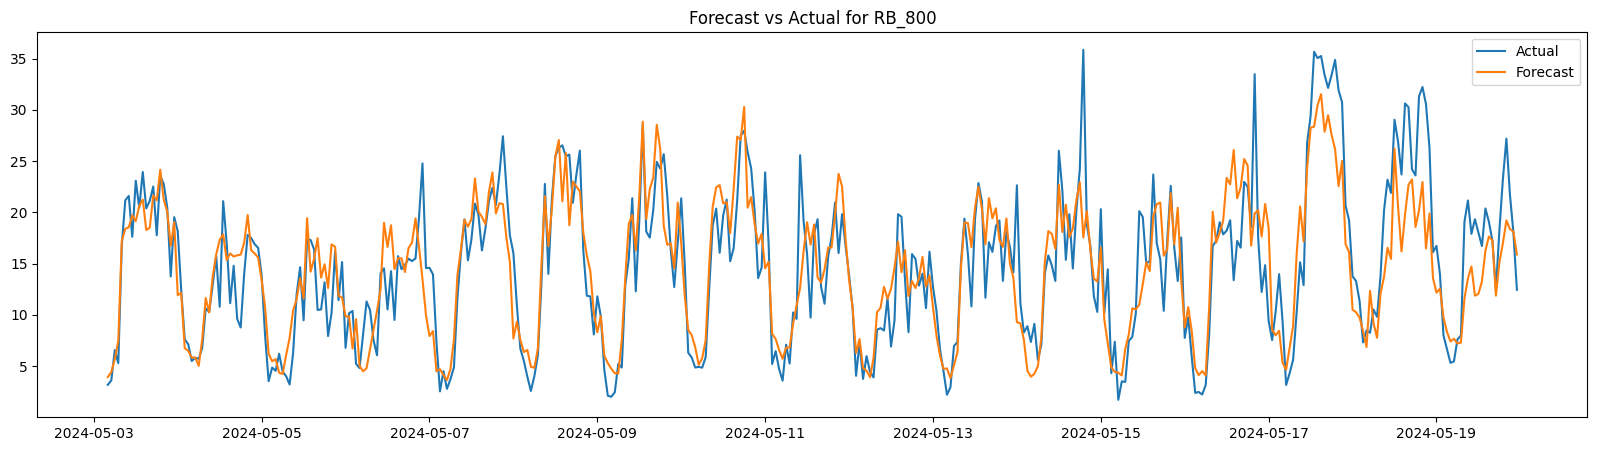

In [22]:
plt.figure(figsize=(20, 5))
plt.plot(test_pick_one.index, actual, label='Actual')
plt.plot(test_pick_one.index, predicted, label='Forecast')
plt.legend()
plt.title(f'Forecast vs Actual for {FREQUENCY}')
plt.show()

## Plot components

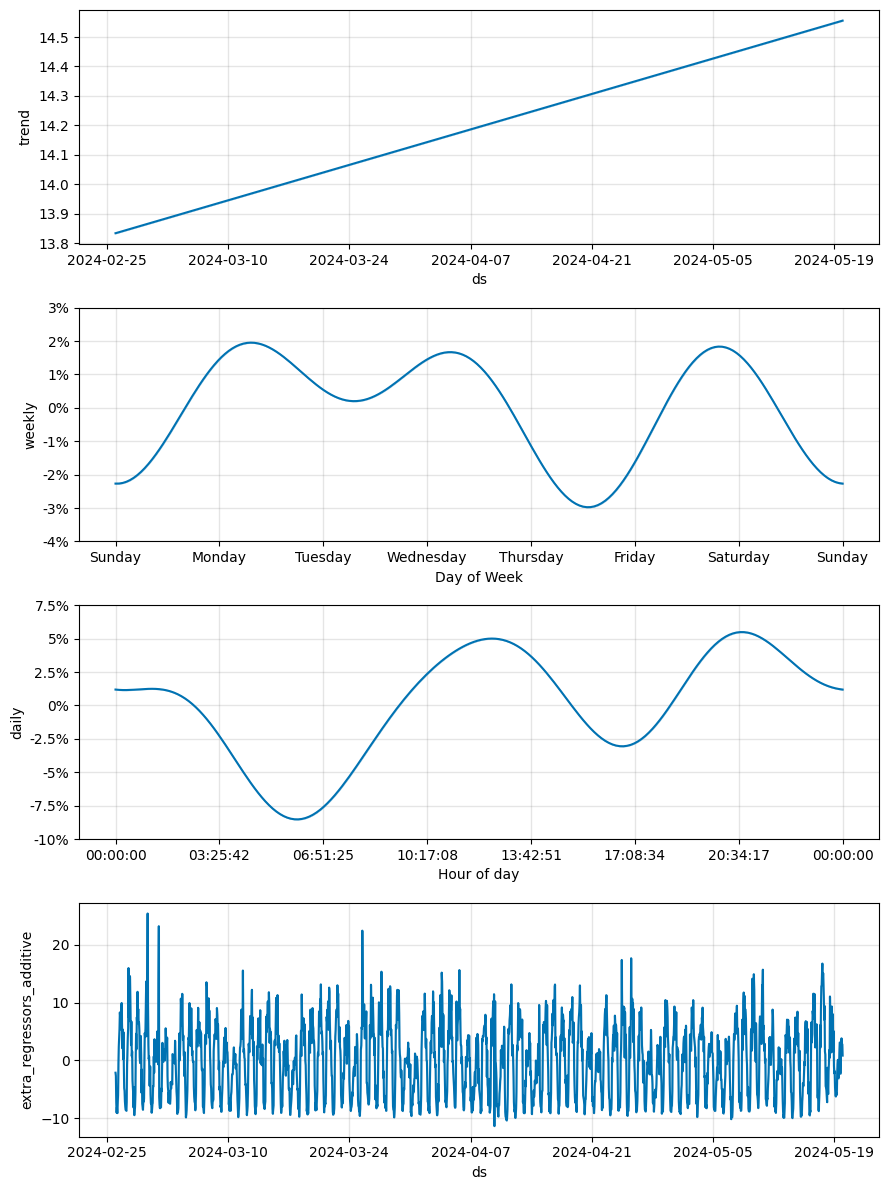

In [23]:
fig = model.plot_components(forecast)
plt.show()